In [1]:
from predator_prey import *

from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

In [2]:
env = gym.make('ma_gym:PredatorPrey5x5-v0')

In [3]:
global device 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

# --------------------------------------------------------------------------------------------------------------


## Deep Q-Learning Network:

In [17]:
class DQN(nn.Module):
    
    def __init__(self, state_size, action_size, use_cuda = True):
        
        #Allow usage of inherited class methods directly:
        super(DQN, self).__init__()
        
        #Enable/Disable using GPU for training:
        self.use_cuda = use_cuda
        
        ##---NEURAL NETWORK ARCHITECTURE---#:
        
        self.input_layer = nn.Linear(state_size, 32)
        self.hidden_layer1 = nn.Linear(32, 64)
        self.hidden_layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, action_size)
        
        #----------------------------------#
        
        self.loss_fn = nn.L1Loss()
        self.optimizer = torch.optim.RMSprop(params = self.parameters(),
                                             lr = 0.1)    
    
    def forward(self, state):
        
        X = F.relu(self.input_layer(state))
        X = F.relu(self.hidden_layer1(X))
        X = F.relu(self.hidden_layer2(X))
        action_values = self.output_layer(X)
        
        return action_values
    
    

## Training Function:

In [161]:
def train_model(model, X, Y, epochs = 10):
    
    global device
    
    X = X.to(device)
    Y = Y.to(device)
    
    for epoch in range(epochs):
        
        model.train()
        
        y_pred = model(X).squeeze()
        
        model.optimizer.zero_grad()
        
        model.loss_fn.backward()
        
        model.optimizer.step()


In [172]:
idx = np.random.default_rng().choice(5, size = 3, replace = False)
A = np.random.randint(15625, size = 10)
A = [encoding_to_state(s) for s in A]
A = np.array(list(map(string_to_state, A)))*0.1
A = torch.tensor(A, dtype = torch.float32)

In [191]:
B = np.random.randint(5, size = 10)
np.where(B==0)

(array([1, 4, 5], dtype=int64),)

In [176]:
with torch.inference_mode():
    model = DQN(6, 25)
    Y = model(A).numpy()
Y.shape

array([[-0.03336988, -0.14240186, -0.04602407,  0.15938702, -0.09666204,
        -0.22237086,  0.05894099, -0.14904375, -0.04688868,  0.02105118,
        -0.05982035, -0.19932953, -0.12706402,  0.27775303, -0.17605948,
         0.04909543,  0.06951721,  0.11740568, -0.04068892,  0.14326297,
        -0.06216986, -0.05576455, -0.06897743,  0.02934251, -0.03230783],
       [-0.03245573, -0.15047891, -0.03733453,  0.1570821 , -0.09584244,
        -0.21293953,  0.0633012 , -0.1452517 , -0.05628642,  0.01110583,
        -0.05070911, -0.19379397, -0.12605897,  0.25868675, -0.18162906,
         0.04157753,  0.07531892,  0.12275115, -0.04631899,  0.14249076,
        -0.06335084, -0.05073947, -0.07170766,  0.01973122, -0.01848933],
       [-0.03289139, -0.15391979, -0.05418544,  0.16592222, -0.09696062,
        -0.22825846,  0.05729946, -0.14290148, -0.03791624,  0.01338261,
        -0.049636  , -0.19898671, -0.12140583,  0.27768135, -0.18616048,
         0.0469959 ,  0.06512801,  0.12995975, -0

In [155]:
def string_to_state(state_string):
    
    return [int(s) for s in state_string]

## Agent: 

In [49]:
class DQN_Agent():
    
    def __init__(self, env, name, use_cuda = True):
        
        #Name of the agent:
        self.name = name
        
        #Environment properties
        self.env = env
        self.n = len(self.env.observation_space) + 1              # 1 prey
        self.state_size = 2*self.n
        self.num_states = 5**(self.state_size) # 5 rows/columns squared for area and multiplied by number of agents including prey
        self.num_actions = 5*5
        
        #DQN parameters:
        self.replay_memory = np.zeros((0, 4))
        self.Q = DQN(self.state_size, self.num_actions)    
        self.Q_target = DQN(self.state_size, self.num_actions)
        
        #Evaluation parameters:
        self.num_visits = np.zeros((self.num_states, self.num_actions))
        self.episode_lengths = np.array([])
        self.successful_episodes = 0
        self.total_rewards = np.array([])   #Because taking average rewards defeats the point of prefering faster episodes
        
        #Training parameters
        self.epsilons = np.array([])
        self.gammas = np.array([])
        self.alphas = np.array([])
        
        
    def get_state_from_env(self):
    
        a1_pos = str(self.env.agent_pos[0][0]) + str(self.env.agent_pos[0][1])
        a2_pos = str(self.env.agent_pos[1][0]) + str(self.env.agent_pos[1][1])
        prey_pos = str(self.env.prey_pos[0][0]) + str(self.env.prey_pos[0][1])

        state_string = a1_pos + a2_pos + prey_pos
        state_encoding = state_to_encoding(state_string)

        return state_string, state_encoding
    
    
    def choose_action(self, state_encoding, epsilon):

        action = [0, 0]
        
        state = torch.tensor([int(s) for s in encoding_to_state(state_encoding)]) * 0.1       #Normalizing to a 0 to 1 scale
        
        explore = np.random.choice([False, True], p = [1 - epsilon, epsilon])
        if explore:
            action_encoding = np.argmin(self.num_visits[state_encoding, :])
        else:
            action_values = Q(state)
            action_encoding = int(torch.argmax(action_values))

        action_string = encoding_to_action(action_encoding)
        action[0], action[1] = int(action_string[0]), int(action_string[1])
        
        return action, action_string, action_encoding
    
    
    def update_weights(self, model, target_model, gamma, mini_batch_size = 10):
        
        n = self.replay_memory.size[0]
        
        if n > mini_batch_size:
            
            idx = np.random.default_rng().choice(n, size = mini_batch_size, replace = False) #Non repeated random choice
            samples = self.replay_memory[idx, :]
            
            X_strings = [encoding_to_state(s) for s in samples[:, 0]]
            X = torch.tensor(list(map(string_to_state, X_strings))) * 0.1
            
            X_target_strings = [encoding_to_state(s) for s in samples[:, 3]]
            X_targets = torch.tensor(list(map(string_to_state, X_target_strings))) * 0.1
            
            with torch.inference_mode():    
                
                Y = model(X).numpy()
                Y_targets = target_model(X_targets).numpy()
            
                actions = samples[:, 1]
                rewards = samples[:, 2]
                terminal_states = np.where(rewards == 1)
                non_terminal_states = np.where(rewards != 1)
                
                Y[:, terminal_states] = rewards[terminal_states]
                Y[:, non_terminal_states] = rewards[non_terminal_states] + gamma * Y_targets[:, non_terminal_states]
            
            train_model(model, X, Y, epochs = 10)
        
    
    
    def train_DQN(self, gammas, epsilons, save = False):
        
        _ = self.env.reset()
        self.env.render()
        _ = input("Ready to start?")
        
        num_episodes = gammas.size
        
        for ep in range(num_episodes):
            
            _ = self.env.reset()
            self.env.render()
            
            rewards = []
            
            dones = [False for _ in range(self.env.n_agents)]
            steps = 0
            
            state_string, state_encoding = self.get_state_from_env()
            
            while (not all(dones)) and steps<100:
                 
                action, action_string, action_encoding = self.choose_action(state_string, state_encoding, epsilon)
                
                _, _, dones, _ = self.env.step(action)
                
                prev_state_string = state_string[:]
                prev_state_encoding = state_encoding
                state_string, state_encoding = self.get_state_from_env()
                reward = get_custom_reward(prev_state_encoding, action_encoding, state_encoding)
                
                transition = np.array([[prev_state_encoding, action_encoding, reward, state_encoding]])
                
                #Store transition:
                self.replay_memory = np.append(self.replay_memory, transition, axis = 0)
                
                rewards.append(reward)
                
                #START HEREEEEEE @@@######################@$(%(*$&)#($*(#@*)))
                self.update_weights()
                
            
            
                
    def analyse_episode(self):
        
        dones = [False for _ in range(self.env.n_agents)]
        action = [0, 0]
        reward = [0, 0]
        
        _ = self.env.reset()
        count = 0
        
        self.env.render()
        _ = input("Press Enter to start simulation")
        
        while not all(dones):
            
            #clear_output(wait = True)
            self.env.render()
            
            state_string, state_encoding = self.get_state_from_env()
            action, action_string, action_encoding = self.choose_action(state_encoding, epsilon = 0)
            
            print(action_dict[action[0]], action_dict[action[1]])
            print("\nCurrent state in their representation = ", state_string)
            _ = input("Does the action make sense? Press Enter to execute")
            _, _, dones, _ = self.env.step(action)
            print("Is agent done?: ", dones)
            self.env.render()
            
            
    def save_agent(self):
        
        #Agent properties:
        np.save(self.name + "/" + self.name + "_values.npy", self.values)
        
        #Evaluation parameters:
        np.save(self.name + "/" + self.name + "_num_visits.npy", self.num_visits)
        np.save(self.name + "/" + self.name + "_episode_lengths.npy", self.episode_lengths)
        np.save(self.name + "/" + self.name + "_successful_episodes.npy", self.successful_episodes)
        np.save(self.name + "/" + self.name + "_total_rewards.npy", self.total_rewards)
        
        #Training parameters:
        np.save(self.name + "/" + self.name + "_epsilons.npy", self.epsilons)
        np.save(self.name + "/" + self.name + "_gammas.npy", self.gammas)
        np.save(self.name + "/" + self.name + "_alphas.npy", self.alphas)
        
    
    def load_agent(self):
        
        #Agent properties:
        self.values = np.load(self.name + "/" + self.name + "_values.npy")
        
        #Evaluation parameters:
        self.num_visits = np.load(self.name + "/" + self.name + "_num_visits.npy")
        self.episode_lengths = np.load(self.name + "/" + self.name + "_episode_lengths.npy")
        self.successful_episodes = np.load(self.name + "/" + self.name + "_successful_episodes.npy")
        self.total_rewards = np.load(self.name + "/" + self.name + "_total_rewards.npy")
        
        #Training parameters:
        self.epsilons = np.load(self.name + "/" + self.name + "_epsilons.npy")
        self.gammas = np.load(self.name + "/" + self.name + "_gammas.npy")
        self.alphas = np.load(self.name + "/" + self.name + "_alphas.npy")


In [51]:
agent = Agent(env, name = "TD_agent_1")

In [12]:
agent.values = np.load("TD_values.npy")
print(agent.values)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [63]:
agent.env.close()

In [56]:
num_episodes = 10000

gamma = np.ones(num_episodes) * 0.9
epsilon = np.ones(num_episodes) * 0.2
alpha = np.ones(num_episodes) * 0.1

agent.TD_control(gamma, epsilon, alpha, save = True)

1 1
Episodes completed =  9999


In [64]:
agent.successful_episodes

8887

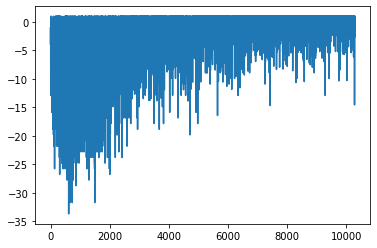

In [58]:
plt.plot(agent.total_rewards)

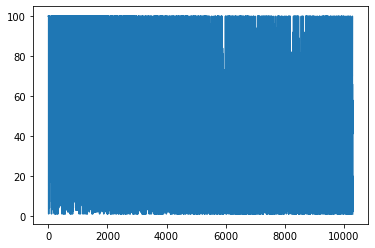

In [59]:
plt.plot(agent.episode_lengths)

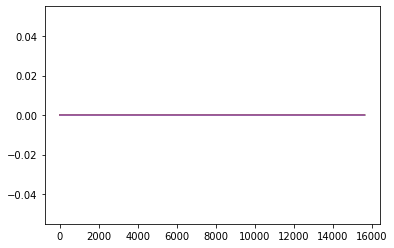

In [60]:
plt.plot(agent.num_visits)

In [64]:
np.max(agent.total_rewards)

-0.01

In [62]:
action_dict = {0:"Down", 1:"Left", 2:"Up", 3:"Right", 4:"Noop"}
agent.analyse_episode()

Press Enter to start simulation
Up Up

Current state in their representation =  331220
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Down Right

Current state in their representation =  230220
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Right

Current state in their representation =  330320
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Down Right

Current state in their representation =  320420
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Left Noop

Current state in their representation =  420410
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Right Down

Current state in their representation =  410400
Does the action make sense? Press Enter to execute
Is agent done?:  [False, False]
Up Noop

Current state in their representation =  421410
Does the action make sense? Press Enter to execute
Is agent

KeyboardInterrupt: Interrupted by user

In [22]:
def value_heatmap(values, half_state = "2233"):
    
    heatmap = np.zeros((5,5))
    
    for i in range(5):
        for j in range(5):

            state_encoding = state_to_encoding(str(i) + str(j) + half_state)
            heatmap[i, j] = np.mean(values[state_encoding, :])
            
    return heatmap

[[-2.88029515e+00 -2.73801415e+00 -1.70417279e+00 -1.41973136e-01
   0.00000000e+00]
 [-3.32012845e+00 -3.16612801e+00 -1.78982501e+00 -8.45625087e-01
   0.00000000e+00]
 [-3.52152620e+00 -3.34311050e+00  0.00000000e+00 -4.00000000e-04
  -1.30831872e-01]
 [-2.97888619e+00 -3.10997406e+00 -2.20607257e-01  0.00000000e+00
  -2.93791867e-01]
 [-3.17500251e+00 -2.80480704e+00 -2.52051120e+00 -6.65981825e-01
  -1.64005864e+00]]


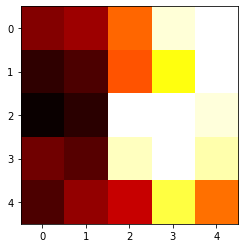

In [65]:
heatmap = value_heatmap(agent.values, half_state = "2233")
print(heatmap)
plt.imshow(heatmap, cmap="hot", interpolation="nearest")

(15625, 25)


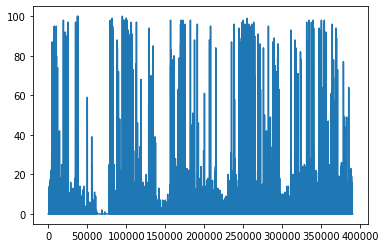

In [66]:
print(agent.num_visits.shape)
plt.plot(agent.num_visits[:].flatten())

In [68]:
np.min(agent.num_visits)

0.0